### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
import time



Using TensorFlow backend.


In [2]:
# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
def tracked_states_init():
    state_action_pair = [((2, 18, 0), (0, 0)),
                         ((0, 0, 0), (0, 0)),
                         ((0, 0, 0), (0, 1)),
                         ((0, 0, 0), (0, 2)),
                         ((0, 0, 0), (0, 3)),
                         ((0, 0, 0), (0, 4)),
                         ((4, 21, 5), (1, 3)),
                         ((4, 21, 0), (0, 0)),
                         ((1, 9, 1), (0, 0)),
                         ((4, 0, 2), (3, 2)),
                         ((0, 6, 0), (4, 1)),
                         ((3, 0, 3), (0, 0)),
                         ((1, 10, 0), (3, 1)),
                         ((1, 0, 0), (1, 2)),
                         ((4, 4, 4), (4, 1))]
    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = dict()
        tracked_states[state][action] = list()

In [5]:
tracked_states = dict()

tracked_states_init()
tracked_states

{(2, 18, 0): {(0, 0): []},
 (0, 0, 0): {(0, 0): [], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): []},
 (4, 21, 5): {(1, 3): []},
 (4, 21, 0): {(0, 0): []},
 (1, 9, 1): {(0, 0): []},
 (4, 0, 2): {(3, 2): []},
 (0, 6, 0): {(4, 1): []},
 (3, 0, 3): {(0, 0): []},
 (1, 10, 0): {(3, 1): []},
 (1, 0, 0): {(1, 2): []},
 (4, 4, 4): {(4, 1): []}}

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, epsilon_decay=0.00001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95     # default
        self.learning_rate =  0.01      # default

        self.epsilon = 1                # default
        self.epsilon_max = 1.0          # default
        self.epsilon_decay = epsilon_decay    # default
        self.epsilon_min = 0.001        # default
        
        self.batch_size = 32            # default
        # create replay memory using deque
        self.memory = deque(maxlen=2000)# default
        
#         # Initialize the value of the states tracked
#         self.states_tracked = []
#         # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
#         self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layer
        model.add(Dense(32, input_dim=self.state_size, activation="relu", kernel_initializer='he_uniform'))
        model.add(Dense(32, activation="relu", kernel_initializer='he_uniform'))
        # output layer
        model.add(Dense(self.action_size, activation="relu", kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
#         print(model.summary)
        return model



    def get_action(self, state):
        
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        
        possible_requests_index, actions = env.requests(state)
        
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            selected_action = random.choice(actions)
    
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
        
            state_encod = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            # Use the model to predict the Q_values.
            predicted_q_values = self.model.predict(state_encod)
            # truncate the array to only those actions that are part of the ride  requests.
            filter_q_values = [predicted_q_values[0][i] for i in possible_requests_index]
            
            index_max_q_value = np.argmax(np.array(filter_q_values))
            selected_action = actions[index_max_q_value]
        
        # verifying correct action space
        for i, action in enumerate(env.action_space):
            if selected_action == action:
                selected_action_index = i
                break
        
        return selected_action_index, selected_action



    def append_sample(self, state, action, reward, next_state, terminal):
        
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal)) 

    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards = [], []
            terminal = []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_flag = mini_batch[i]
                
                update_input[i] = env.state_encod_arch1(state)  
                update_output[i] = env.state_encod_arch1(next_state)
                
                actions.append(action)
                rewards.append(reward)
                terminal.append(terminal_flag)

            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if terminal[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + (self.discount_factor * np.max(target_qval[i]))   
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

            
    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file, pickle.HIGHEST_PROTOCOL)

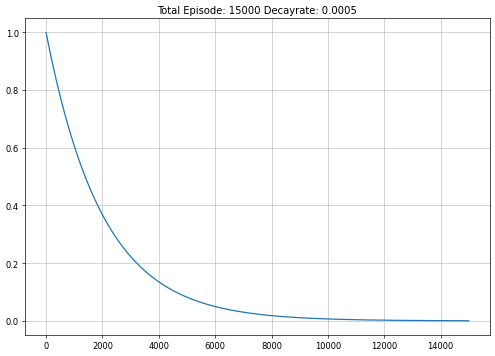

In [8]:
#### Epsilon-decay sample function

Episodes = 15000
decay = 0.0005

# Episodes = 10000
# decay = 0.0008

# Episodes = 100
# decay = 0.08

time = np.arange(0, Episodes)
epsilon = []
for i in range(0, Episodes):
    epsilon.append((1 - 0.001) * np.exp(-decay*i))
    
plt.figure(figsize=(10,7), dpi= 60)
plt.plot(time, epsilon)
plt.title("Total Episode: "+str(Episodes)+ " Decayrate: "+str(decay))
plt.grid(axis='both', alpha=.8)
plt.show()

In [9]:
save_threshold = int(Episodes*0.2)
save_status_threshold = int(Episodes*0.1) # if episode = 100*0.1 =10 if 1000*0.1=100 

max_total_time_per_episode = 30 * 24
m, t, d = 5, 24, 7
state_size = m + t + d

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Call the DQN agent
agent = DQNAgent(action_size=len(action_space), state_size=state_size, epsilon_decay=decay)

# useful metric for tracking
rewards_per_episode = []
no_of_rides_per_episode = []
total_time_per_episode = []
epsilon = []

In [10]:
dict_actions = dict([(act, i) for i, act in enumerate(env.action_space)]) # creating dict of act with index as value

def update_tracked_states():
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1,36)
        q_predict = agent.model.predict(encoded_state)

        for action in tracked_states[state].keys():    # one state can have multiple actions
            if action in dict_actions: 
                action_index = dict_actions[action]    # returning action index    
            q_value = q_predict[0][action_index]       # getting perticular q_value(predicted NN) of that action
            tracked_states[state][action].append(q_value)

### DQN block

In [11]:

import time

start_time = time.time()
score_tracked = []


for episode in range(Episodes):

    terminal_state = False
    
    total_time = 0      # Total time driver rode in this episode
    total_reward = 0
    no_of_rides = 0
    
    
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()
    
#     # Save the initial state so that reward can be tracked if initial state is [0,0,0]
#     initial_state = env.state_init

    while not terminal_state:
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index, action = agent.get_action(state)
        
        # 2. Evaluate your reward and next state
#         print(state, action)
        next_state, reward, duration = env.next_state_func(state, action, Time_matrix)
        total_time += duration    # for tracking the state
        total_reward += reward    # for tracking the state
        
        if total_time >= max_total_time_per_episode:
            terminal_state = True
            
        # 3. Append the experience to the memory
#         print("Episode:{}, State:{}, Action:{}, Reward:{}, NextState:{}, Time:{}" \
#                 .format(episode, state, action, total_reward, next_state, total_time))
        
        agent.append_sample(state, action_index, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        state = next_state
        no_of_rides += 1         # for tracking the state
        
    # 5. Keep a track of rewards, Q-values, loss
    rewards_per_episode.append(total_reward)
    no_of_rides_per_episode.append(no_of_rides)
    total_time_per_episode.append(total_time)
    
    # decay in epsilon after each episode
    agent.epsilon = (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)
    epsilon.append(agent.epsilon) # for tracking the state
    
    if episode%save_status_threshold ==0:
        update_tracked_states()
        print(f"update_tracked_states saved at Episode:{episode}")
    
    if episode % save_threshold == 0:
        agent.save(name="model_weight.pkl")
        print(f"Model saved at Eps:{episode}")
    
    #     print(f"Episode:{episode} Timetake: {((time.time() - start_time)//60)}min\n")
    elapsed_time = time.time() - start_time
    print("Episode:{} Reward:{} Rides:{} Total Ride Time:{} Timetake:{}min " \
              .format(episode, total_reward, no_of_rides, total_time, (elapsed_time//60)))
        
# update_tracked_states()
agent.save(name="model_weight.pkl")
elapsed_time = time.time() - start_time
print(f"Elapsed time : {elapsed_time/60//60}hour {int(elapsed_time/60%60)}mins" )

update_tracked_states saved at Episode:0
Model saved at Eps:0
Episode:0 Reward:-154 Rides:129 Total Ride Time:722 Timetake:0.0min 
Episode:1 Reward:-338 Rides:132 Total Ride Time:721 Timetake:0.0min 
Episode:2 Reward:-126 Rides:129 Total Ride Time:720 Timetake:0.0min 
Episode:3 Reward:-159 Rides:157 Total Ride Time:723 Timetake:0.0min 
Episode:4 Reward:-235 Rides:150 Total Ride Time:722 Timetake:0.0min 
Episode:5 Reward:-227 Rides:138 Total Ride Time:733 Timetake:0.0min 
Episode:6 Reward:-338 Rides:142 Total Ride Time:721 Timetake:0.0min 
Episode:7 Reward:-151 Rides:140 Total Ride Time:725 Timetake:0.0min 
Episode:8 Reward:-397 Rides:137 Total Ride Time:722 Timetake:0.0min 
Episode:9 Reward:-334 Rides:144 Total Ride Time:722 Timetake:0.0min 
Episode:10 Reward:-396 Rides:135 Total Ride Time:720 Timetake:0.0min 
Episode:11 Reward:-243 Rides:156 Total Ride Time:729 Timetake:0.0min 
Episode:12 Reward:-411 Rides:133 Total Ride Time:723 Timetake:0.0min 
Episode:13 Reward:-73 Rides:132 Total 

In [12]:
print(f"Total time take for Episode {Episodes}:  {elapsed_time/60//60}hour {int(elapsed_time/60%60)}mins" )

Total time take for Episode 15000:  2.0hour 55mins


### Tracking Convergence

In [13]:
tracked_states_plotting = []
# checking how many state are tracked...
# accepting any state value having more than 1 tracked q_values
for state in tracked_states.keys():
    for action in tracked_states[state].keys():
        
        q_values_track_count = len(list(filter(lambda x: x!= 0, tracked_states[state][action])))
        print('state:{} action:{} count:{}'.format(state, action, q_values_track_count))
        
        if q_values_track_count>0:
            tracked_states_plotting.append((state,action))
            

state:(2, 18, 0) action:(0, 0) count:9
state:(0, 0, 0) action:(0, 0) count:9
state:(0, 0, 0) action:(0, 1) count:10
state:(0, 0, 0) action:(0, 2) count:10
state:(0, 0, 0) action:(0, 3) count:10
state:(0, 0, 0) action:(0, 4) count:9
state:(4, 21, 5) action:(1, 3) count:10
state:(4, 21, 0) action:(0, 0) count:9
state:(1, 9, 1) action:(0, 0) count:9
state:(4, 0, 2) action:(3, 2) count:10
state:(0, 6, 0) action:(4, 1) count:10
state:(3, 0, 3) action:(0, 0) count:9
state:(1, 10, 0) action:(3, 1) count:9
state:(1, 0, 0) action:(1, 2) count:10
state:(4, 4, 4) action:(4, 1) count:10


In [14]:
print("total of ",len(tracked_states_plotting)," state and action are tracked.\n", \
      tracked_states_plotting)

total of  15  state and action are tracked.
 [((2, 18, 0), (0, 0)), ((0, 0, 0), (0, 0)), ((0, 0, 0), (0, 1)), ((0, 0, 0), (0, 2)), ((0, 0, 0), (0, 3)), ((0, 0, 0), (0, 4)), ((4, 21, 5), (1, 3)), ((4, 21, 0), (0, 0)), ((1, 9, 1), (0, 0)), ((4, 0, 2), (3, 2)), ((0, 6, 0), (4, 1)), ((3, 0, 3), (0, 0)), ((1, 10, 0), (3, 1)), ((1, 0, 0), (1, 2)), ((4, 4, 4), (4, 1))]


In [15]:
def convergence_graph_plot(state, action):
    """
    Ploting graph for each tracked state using its tracked_q_values
    """
    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {} - Action : {}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

<Figure size 1440x1080 with 0 Axes>

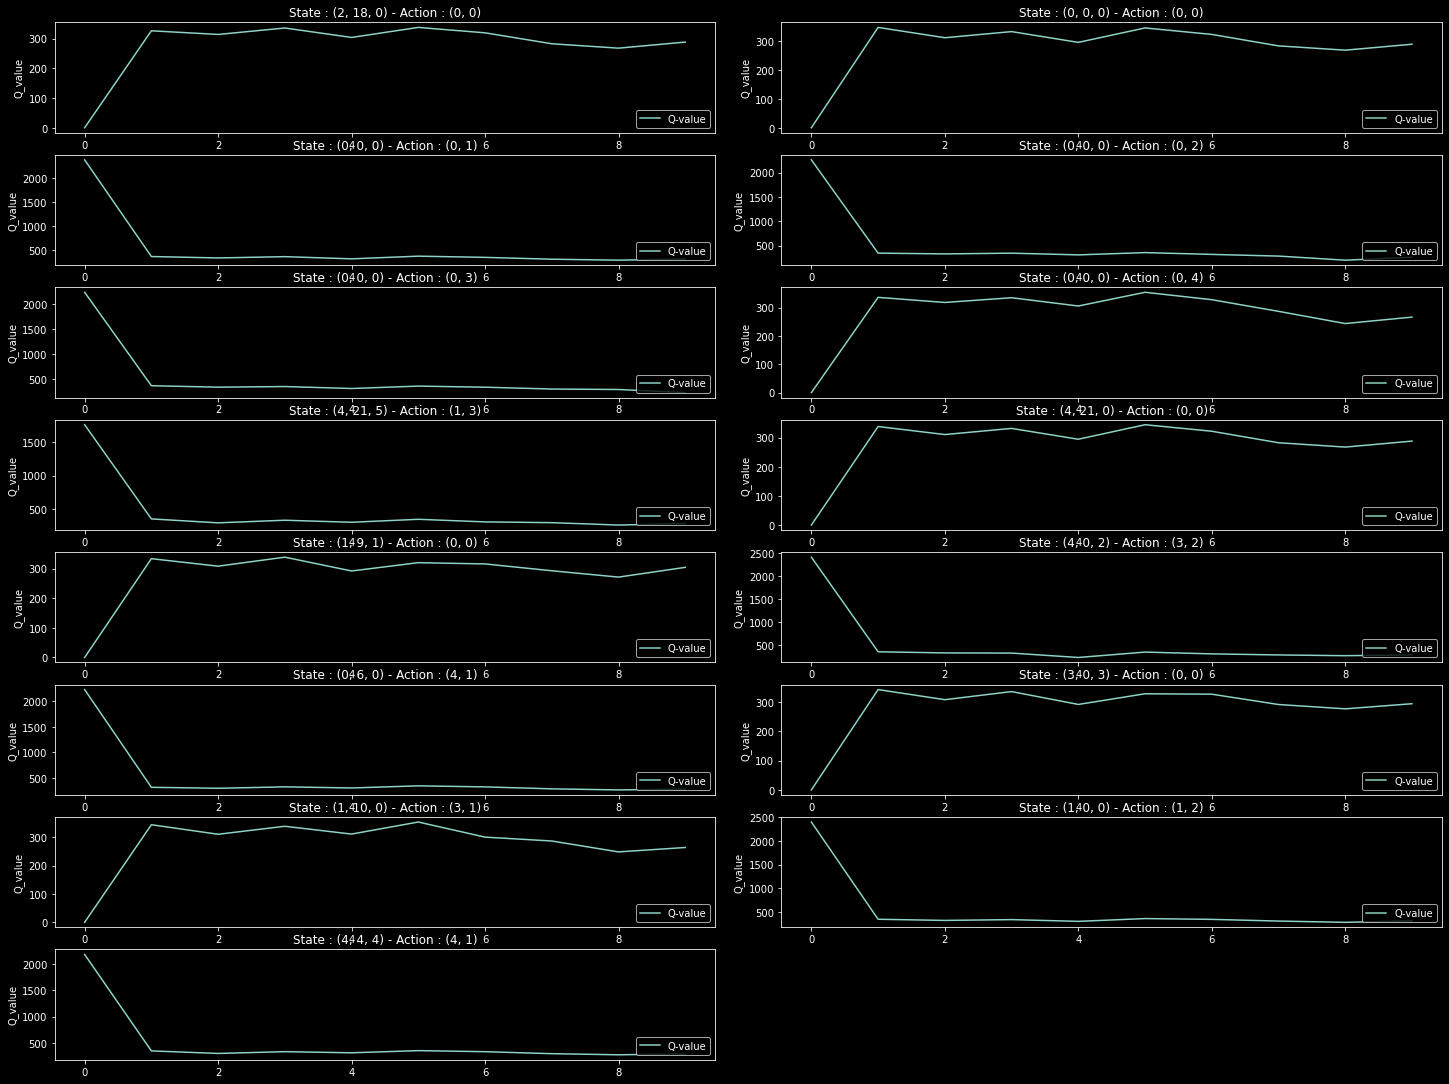

In [16]:
# Ploting graph for each tracked state using its tracked_q_values

plt.figure(0, figsize=(20, 15))
plt.style.use('dark_background')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

len_TSP = len(tracked_states_plotting)+1
half_len_TSP = int(len_TSP/2) # used for rows for ploting subplot

i = 1
for state, action in tracked_states_plotting:
    if i < len_TSP:   
        plt.subplot(half_len_TSP, 2, i)
        convergence_graph_plot(state, action)
        i +=1
        
plt.subplots_adjust(wspace = 0.1, hspace = 0.2)        
plt.show()

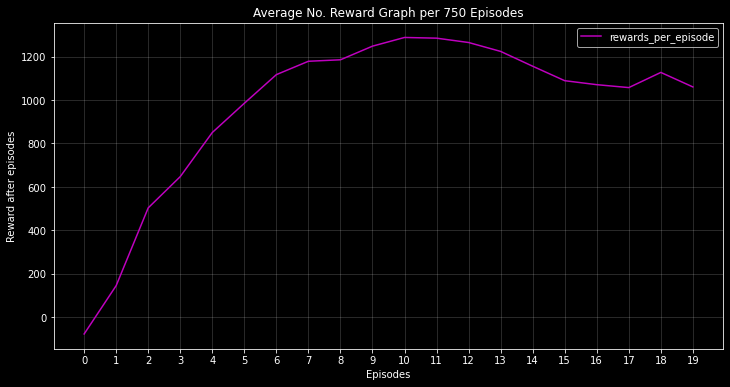

In [17]:
# Reward per Episodes 

avg_rewards_per_episode=[]
spacing = int(Episodes * 0.05)

avg_rewards_per_episode = [np.mean(rewards_per_episode[i:i+spacing]) for i in range(0, Episodes, spacing)]

plt.figure(figsize=(12, 6))
plt.plot(avg_rewards_per_episode, color="m", label = "rewards_per_episode")

plt.xlabel("Episodes")
plt.ylabel("Reward after episodes")
plt.title(f"Average No. Reward Graph per {spacing} Episodes")

plt.xticks(range(0, int(Episodes/spacing), 1))
plt.grid(axis='both', alpha=.2)
plt.legend()

plt.show()

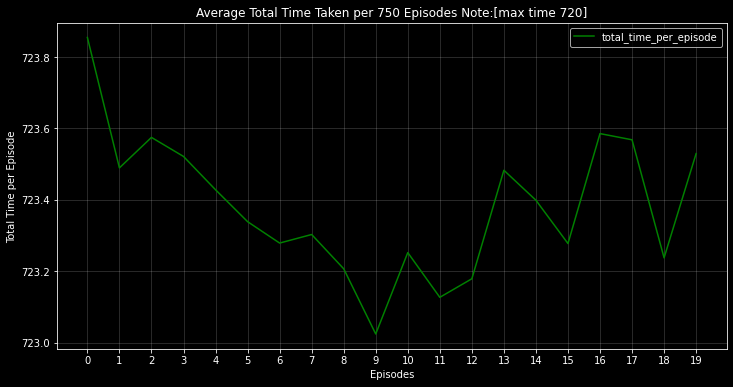

In [18]:
# Total Time per Episode [max time 720]

avg_total_time_per_episode=[]
spacing = int(Episodes * 0.05)

avg_total_time_per_episode = [np.mean(total_time_per_episode[i:i+spacing]) for i in range(0, Episodes, spacing)]



plt.figure(figsize=(12, 6))
plt.plot(avg_total_time_per_episode, color="g", label = "total_time_per_episode")#m

plt.xlabel("Episodes")
plt.ylabel("Total Time per Episode")
plt.title(f"Average Total Time Taken per {spacing} Episodes Note:[max time 720]")

plt.xticks(range(0, int(Episodes/spacing), 1))
plt.grid(axis='both', alpha=.2)
plt.legend()
plt.show()

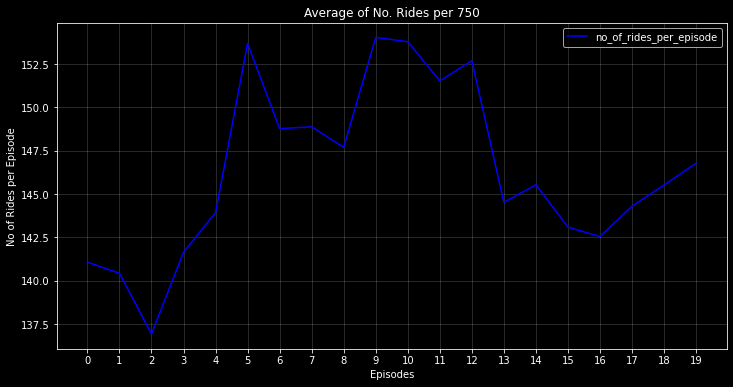

In [19]:
# No of Rides per Episode

avg_no_of_rides_per_episode=[]
spacing = int(Episodes * 0.05)

avg_no_of_rides_per_episode = [np.mean(no_of_rides_per_episode[i:i+spacing]) for i in range(0, Episodes, spacing)]

plt.figure(figsize=(12, 6))
plt.plot(avg_no_of_rides_per_episode, color="b", label = "no_of_rides_per_episode")

plt.xlabel("Episodes")
plt.ylabel("No of Rides per Episode")
plt.title(f"Average of No. Rides per {spacing}")

plt.xticks(range(0, int(Episodes/spacing), 1))
plt.grid(axis='both', alpha=.2)
plt.legend()

plt.show()